In [1]:
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
df_all = pd.read_pickle('./data/df_all_lemma.pkl')
print(len(df_all))
df_all.head(1)

2524


,comments,description,duration,event,film_date,languages,link,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,transcript,url,views
0,4553.0,Sir Ken Robinson makes an entertaining and pro...,1164.0,TED2006,1.140826e+09,60.0,NaN,Ken Robinson,Ken Robinson: Do schools kill creativity?,1.0,1.151367e+09,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,it been great hasnt it. ive been blown away by...,https://www.ted.com/talks/ken_robinson_says_sc...,47227110.0


In [32]:
docs_all = list(df_all['transcript'])

from nltk.corpus import stopwords

stops_standard = stopwords.words('english')
stops_custom = ['shes','youll','ill','yeah','th','yes','oh',
                'ok','okay','might','ha','mr','bg','ms',
                'mrs','ca','em','da','ted','pm','hey','al']+[re.sub('[^A-Za-z ]+', '', w) for w in stops_standard]
stop_list = list(set(stops_standard + stops_custom))

print(stop_list)

['theirs', 'was', 'both', "couldn't", "you'd", 'were', 'no', 'our', 'ca', 'or', 'do', 'most', 'wasnt', 'doesn', 'his', 'he', 'hey', 'nor', 'shant', 'isnt', 'doesnt', 'myself', 'with', 'very', "shouldn't", 'we', 'don', 'might', 'but', 'and', "don't", 'because', 'bg', 'so', 'am', 'arent', 'them', 'd', 'can', 've', 'below', 'doing', 'only', 'itself', 're', 'mrs', 'on', 'same', "she's", 'from', "haven't", 'mightn', 'wasn', 'should', 'under', 'ha', 'about', 'than', 'hadn', 'yourselves', 'o', 'yeah', 'that', 'wouldn', 'a', 'of', 'al', 'too', "mustn't", "needn't", 'down', 'those', 'me', 'da', 'other', "wasn't", 'before', "you're", 'her', 'after', "didn't", "isn't", "weren't", 'who', 'further', 'now', 'hasn', 'against', 'ma', 'this', 'youre', 'above', 'havent', 'mustnt', 'weren', 'into', 'themselves', 'an', 'neednt', 'i', 'it', 'they', 'to', 'himself', 'needn', 'once', 'won', 'some', "mightn't", 'ok', 'aren', 'hadnt', 'couldn', 'youd', 'dont', 'at', 'the', 'few', 'been', 'ain', 'just', 'is', '

In [33]:
docs = docs_all

from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 2000
n_features = 2000
n_components = 50
n_top_words = 10
n_gram = 1
alpha = 0.1
stop_choice= stop_list

max_df = 0.3
min_df = 5
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df,
                                   ngram_range=(n_gram,n_gram),
                                   max_features=n_features,
                                   stop_words=stop_choice)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(docs)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=alpha, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Extracting tf-idf features for NMF...
done in 2.920s.
Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=2000...
done in 8.320s.

Topics in NMF model (Frobenius norm):
Topic #0: book felt learned night read somebody everybody age feeling name
Topic #1: dna gene genome genetic bacteria virus specie sequence molecule organism
Topic #2: energy nuclear climate fuel solar carbon electricity coal emission co
Topic #3: drug disease vaccine virus hiv treatment epidemic trial flu health
Topic #4: computer software code algorithm device digital program learning interface mit
Topic #5: city space neighborhood street urban community map mayor architecture york
Topic #6: brain neuron cortex memory disorder signal region pattern activity area
Topic #7: robot leg sensor artificial motor intelligence video control motion lab
Topic #8: music musician play instrument piece playing hear string sound note
Topic #9: war soldier violence conflict afghanistan weapon mi

In [28]:
X = nmf.fit_transform(tfidf)


In [20]:
# X[1000].argmax()

In [41]:
def save_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return top_words

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
n_top_words = 10
NMF_top_words = save_top_words(nmf, tfidf_feature_names, n_top_words)

In [42]:
df = pd.DataFrame(NMF_top_words)
df.to_pickle('./data/NMF_top_words.pkl')
df.head()

,0,1,2,3,4,5,6,7,8,9
0,book,felt,learned,night,read,somebody,everybody,age,feeling,name
1,dna,gene,genome,genetic,bacteria,virus,specie,sequence,molecule,organism
2,energy,nuclear,climate,fuel,solar,carbon,electricity,coal,emission,co
3,drug,disease,vaccine,virus,hiv,treatment,epidemic,trial,flu,health
4,computer,software,code,algorithm,device,digital,program,learning,interface,mit


### Find related talks

In [7]:
import sklearn.neighbors.kd_tree as kdtree

In [35]:
def match_score(list1, list2):
    m = len(list1)
    score = 0
    matches = 0
    for title in list2:
        if title in list1:
            score += m - list1.index(title)
            matches += 1
    return (score, matches)

In [36]:
tree = kdtree.KDTree(X, leaf_size=10) 
scores = []
matches = []
for N in range(2467):
    # N = 1
    if N%100==0:
        print(N)
    dist, ind = tree.query([X[N]], k=20)  
    list1 = []
    for i in ind[0]:
        list1.append(df_all.iloc[i].title)
    list2 = []
    df_related = pd.DataFrame(eval(df_all.iloc[N]['related_talks']))
    for k in range(len(df_related)):
        items = list(df_all[df_all['title']==df_related.iloc[k]['title']].title)
        if len(items)>0:
            list2.append(items[0])
    scores.append(match_score(list1,list2)[0])
    matches.append(match_score(list1,list2)[1])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


In [37]:
sum(scores)/2467

21.18443453587353

In [38]:
sum(matches)/2467

1.650993109039319

In [61]:
tree = kdtree.KDTree(X, leaf_size=10) 
N = 2060
dist, ind = tree.query([X[N]], k=20)  
for i in ind[0]:
    print(i,'\t',df_all.iloc[i].title)
#     print(i,'\t',df_all.iloc[i].views)
#     print(df_all.iloc[i].tags)

2060 	 My year of saying yes to everything
1498 	 The art of misdirection
1852 	 What I learned as a kid in jail
311 	 Flow, the secret to happiness
2125 	 Can you really tell if a kid is lying?
78 	 A philosophical quest for our biggest problems
1050 	 Life's third act
1165 	 The journey across the high wire
1665 	 The Museum of Four in the Morning
1116 	 Everyday moments, caught in time
2219 	 The beauty of what we'll never know
1946 	 How I learned to communicate my inner life with Asperger's
1471 	 DJ decks made of ... paper
2328 	 Asking for help is a strength, not a weakness
2454 	 There's more to life than being happy
1791 	 The art of stillness
853 	 A life lesson from a volunteer firefighter
706 	 The art of choosing
1640 	 Be passionate. Be courageous. Be your best.
122 	 The  4 a.m. mystery


In [62]:
df_related = pd.DataFrame(eval(df_all.iloc[N]['related_talks']))
for k in range(len(df_related)):
    print(list(df_all[df_all['title']==df_related.iloc[k]['title']].title)[0])
#     print(df_all[df_all['title']==df_related.iloc[k]['title']].views)
#     print(list(df_all[df_all['title']==df_related.iloc[k]['title']].tags))

Your elusive creative genius
How to use data to make a hit TV show
Should you live for your résumé ... or your eulogy?
How to find a wonderful idea
Fashion and creativity
Play is more than just fun


In [38]:
# print(docs_all[395])

### Clustering using KMeans

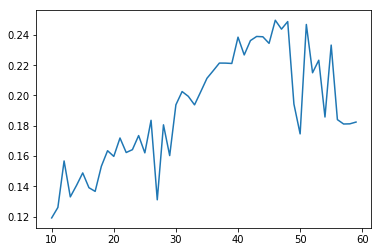

In [44]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn import cluster

n_clusters = 50

# ward = cluster.AgglomerativeClustering(
#     n_clusters=n_clusters, linkage='ward',
#     connectivity=connectivity)
# spectral = cluster.SpectralClustering(
#     n_clusters=n_clusters, eigen_solver='arpack',
#     affinity="nearest_neighbors")
# Xp = spectral.fit_predict(X)
# dbscan = cluster.DBSCAN(eps=params['eps'])

# km = KMeans(n_clusters=50)
# Xt = km.fit_transform(X)

# mu_docs = km.cluster_centers_
# plt.plot(mu_docs.transpose())

# silhouette_score(X, km.labels_, metric='euclidean')

sil_scores = []
iner_scores = []
ks = range(10,60)
for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sil_scores.append(silhouette_score(X, km.labels_, metric='euclidean'))
    iner_scores.append(km.inertia_)
    
plt.plot(ks,sil_scores)


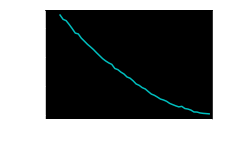

In [57]:
plt.figure(figsize=(3,2))
plt.plot(ks,iner_scores,'c')
plt.rcParams['axes.facecolor'] = 'black'

ax = plt.gca()
ax.set_xlabel('# OF CLUSTERS', fontsize=14, fontweight='bold')
ax.set_ylabel('INERTIA', fontsize=14, fontweight='bold')
ax.set_xlim([5,60])
# ax.set_ylim([0,100])

ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('k')
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('k')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')

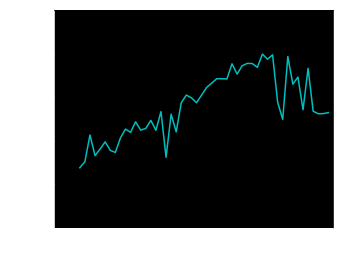

In [56]:
plt.figure(figsize=(5,4))
plt.plot(ks,sil_scores,'c')
plt.rcParams['axes.facecolor'] = 'black'

ax = plt.gca()
ax.set_xlabel('# OF CLUSTERS', fontsize=14, fontweight='bold')
ax.set_ylabel('SILHOUETTE', fontsize=14, fontweight='bold')
ax.set_xlim([5,60])
ax.set_ylim([0.05,0.3])

ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('k')
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('k')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')

In [505]:
tree = kdtree.KDTree(Xt, leaf_size=10) 
# N = 1346
dist, ind = tree.query([Xt[N]], k=10)  
for i in ind[0]:
    print(i,'\t',df_all.iloc[i].title)
#     print(i,'\t',df_all.iloc[i].views)
#     print(df_all.iloc[i].tags)

1599 	 Love -- you're doing it wrong
2343 	 3 ways to plan for the (very) long term
2085 	 How to get back to work after a career break
1395 	 What makes us feel good about our work?
1135 	 How I beat a patent troll
1872 	 How equal do we want the world to be? You'd be surprised
1821 	 The danger of hiding who you are
1870 	 5 ways to kill your dreams
1566 	 The $80 prosthetic knee that's changing lives
609 	 Plug into your hard-wired happiness


In [506]:
df_all.iloc[2343].transcript

'and theyd say great. and ive been seeing that time horizon get shorter and shorter and shorter so much so that i met with a ceo two month ago and i said we started our initial conversation. he go i love what you do. i want to talk about the next six month. we have a lot of problem that we are facing. these are civilizationalscale problem. the issue though is we cant solve them using the mental model that we use right now to try and solve these problem. yes a lot of great technical work is being done but there is a problem that we need to solve for a priori before if we want to really move the needle on those big problem. shorttermism. right. there no march. there no bracelet. there no petition that you can sign to be against shorttermism. i tried to put one up and no one signed. it wa weird. but it prevents u from doing so much. shorttermism for many reason ha pervaded every nook and cranny of our reality. i just want you to take a second and just think about an issue that youre think